# Estimate N_ext from the offshore data

In [1]:
from __future__ import division
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy import stats
from scipy import interpolate
from scipy.integrate import solve_ivp
import math
import matplotlib.pyplot as plt
import pandas as pd # to read excel
# print(f"pandas version is {pd.__version__}")
import seaborn as sns
from array import *
import researchpy as rp
import scipy.stats as stats
%matplotlib inline

from local_functions import Time_to_Hours

import datetime

In [2]:
# 1. Indoor system
#   a. Read data and parameters from excel file

xl = pd.ExcelFile('../data/Parameters.xlsx')
x2 = pd.ExcelFile('../data/Data.xlsx')

# Import parameters into df1
df1 = xl.parse('Parameters')

# assigmment of parameters to values: 
for key,val in zip(df1.Parameter,df1.Indoor_value):
    exec(key + '=val')
    print(key,val)

umol_to_percent_DW 0.0014
n_days 7.0
Duration 7.0
Nint0 1.85
m0 0.15
Nintcrit 4.5
miu 0.04
Nintmax 5.5
Nintmin 0.48
Ks 14.0
Vmax 60.0
Z 0.178
KI 35.0
K0 0.5
Ka 0.05
Topt 18.0
Tmin 5.0
Tmax 35.0
n 5.0
losses20 0.0016
teta 1.047
Sopt 25.0
Smin 3.0
Smax 48.0
Shigh 30.0
Slow 12.0
KN 1.1
dNextoutdt 0.014
dNextindt 0.0
dmoutdt 0.0
Next00  4032.0
dilution 0.0


In [3]:
# # get 9 parameters from indoor_calibration and 6 from brine calibration

miu = 0.033 #0.04
losses20 = 0.003 # 0.004
Nintmax = 4.2 #4.25
Nintcrit = 3.9 #3.9 #3.5 
Ks = 15.5 #25.8 #15.5
Vmax = 199 #199 #150 #199
KI = 78 #15.2 - outdoor the irradiance is high?
K0 = 2.4 #2.1
Ka = 0.123 #0.12 #0.075
Smin = 7.75 #0 #2.5 #5
Sopt = 27 #28 #34
Smax = 44.2 #45
Topt = 20.6 #21.9 # 20.6
Tmax = 36.5 #35.9 # 36.5
n = 5.1
Tmin = 5

In [4]:
# 3. Offshore system - data:
#   a. Read data and parameters
# Import offshore data into df4
df4 = x2.parse('Offshore')

In [5]:
# 1. Convert Time into hours
T = []
for i in df4['Sample'][:]:
    T1 = df4['Timeh'][df4['Sample'].values.tolist().index(i)]
    T2 = df4['Time'][df4['Sample'].values.tolist().index(i)]
    T.append(Time_to_Hours(T1,T2))
    
df4.loc[:,'T'] = T

Tm = []
for i in df4['Sample'][:]:
    T1 = df4['Timem'][df4['Sample'].values.tolist().index(i)]
    T2 = df4['Time'][df4['Sample'].values.tolist().index(i)]
    Tm.append(Time_to_Hours(T1,T2))
    
df4.loc[:,'Tm'] = Tm

In [6]:
'''
Make a reduced DF by filtering the original df to focus on:
Depth: 5m
Fertilizing before cultivation experiment: continuous (long duration)
Cultivation length: ~7 days
Experiments: 2-5
Remove experiments with complete biomass loss

'''
df4f = df4[(df4.Stage == 'f')]
df4i = df4[(df4.Stage == 'i')]
# DWi = df3i.DW
# Ni = df3i.N
#df4f = df4f.assign(DWi = df3i.DW.values)
df4f = df4f.assign(Ni = df4i.N.values)

df4Reduced = df4f[(np.isnan(df4f.DW) != True)&(df4f.Stage == 'f') & (df4f.Depth == 5) & (df4f.Exp != 1) & (df4f.Period == 'Continuous') & (df4f.Days != 12)]
df4Reduced.head()

,Sample,Exp,Period,Cage,Depth,Stage,Days,Timei,Timeh,Timem,...,DGR,RGR,GR,Treatment,Comment,Comment 2,N_Saturation,T,Tm,Ni
62,53.7,2,Continuous,13,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.077470,6.189534,6.385100,1000 / 7 / 18,fertilization in a 35 liter container,NaN,no,170,170,1.76
63,54.7,2,Continuous,14,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.177315,11.528773,12.219628,1000 / 7 / 18,fertilization in a 35 liter container,NaN,no,170,170,NaN
64,55.7,2,Continuous,15,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.192143,12.175506,12.947741,1000 / 7 / 18,fertilization in a 35 liter container,NaN,no,170,170,NaN
65,56.7,2,Continuous,16,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.124470,8.951807,9.364710,NaN,NaN,NaN,no,170,170,NaN
66,57.7,2,Continuous,17,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.129353,9.210430,9.647918,NaN,NaN,NaN,no,170,170,NaN


In [7]:
# Build interpolations functions for temperature data

xCTD = pd.ExcelFile('../data/CTDr.xlsx')
dfCTD = xCTD.parse('HaderaCTD',header=None)

dfCTD.head()

In [ ]:
# Import water temperature data

Twater = dfCTD.iloc[1:42624:1][6].values 

# TCTD = dfCTD.iloc[1:42624:1][6]
# Twater = []
# for i in TCTD:
#     #if type(i) == int:
#     #    i = str(i)
#     Twater.append(i)#float(re.sub(r"\s+", "", i, flags=re.UNICODE)))

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [ ]:
# T_average is a moving average of 1 hour with jumps of 1 hours (6 times 10 minutes)

T_average = moving_average(Twater[::6],6)


In [ ]:
#plt.plot(moving_average(Twater[1::6],6),'r',alpha=.3)
#plt.plot(T_average,'b',alpha=.2)

In [ ]:
# c. Build interpolations functions for temperature and light IMS data
    # 1. Import combined IMS excel for light function
dfims = pd.read_csv('../data/ims.csv',encoding= 'unicode_escape',header=None)


# days = list(range(1,296))
days = np.arange(1,296) # or from day 0? np.arange(296)

I_plot = np.zeros(24*296)
light_hours = np.arange(5,19)
for day in days:
    for hour in light_hours:
        I_plot[(day-1)*24 + hour] = float(dfims.iloc[day][hour-1])


all_hours = np.arange(1,296*24+1)

fI0 = interpolate.interp1d(all_hours, I_plot,kind = 'linear',bounds_error=False, fill_value="extrapolate")

In [ ]:
# 4. Calculate model results for:

In [ ]:
def Offshore_constant_N_new(x,t,Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,S,Z,KI,K0,Ka,Topt,
                Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA):


    Next = x[0] #x[0] # units: [umol N/l]
    Nint = x[1] # units: [% g N/g DW]
    m = x[2] # units: [g DW/l]
    
    Neff = (Nintmax - Nint)/(Nintmax - Nintmin)  # units: [ ]
    if Next <= 0:
        uN = 0
    else: 
        uN = Vmax * Next / (Ks + Next)  # units: [umol N/g DW/h]
    if Nint >= Nintcrit:
        fN = 1
    else:
        fN = ((Nint - Nintmin)/Nint) / ((Nintcrit - Nintmin)/Nintcrit)  # units: [ ]
    fP = 1  #(N:P < 12)


    # density - light penetration effects:
    SD = m * VA # Stocking Density. units: [g DW/ m^2]
    #I_average = (I0 / (Ka * SD)) * (1 - np.exp(-(Ka * SD))) # units: [umul photons/(m^2 s)] #light measured in water, so no need in K0
    #I_average = (I0 / (K0 * Z + Ka * SD)) * (1 - np.exp(-(K0 * Z + Ka * SD))) # units: [umul photons/(m^2 s)]
    I0 = fI0(t)
    #print('I0 is : ' + str(I0))
    I_average = (I0 - K0 * Z) / (Ka * SD) * (1 - np.exp(-(Ka * SD)))
    #print('I_average is: ' + str(I_average))
    fI = I_average / (I_average + KI) # units: [-]
    #print('fI is: ' + str(fI))
    #fI = I0 / (I0 + KI) # units: [-]

    # Add Z effect on I
    Temp = fTemp0(t)
        # Temperature effects:         
    if Temp <= Topt:
        Tx = Tmin
    else:
        Tx = Tmax

    fT = np.exp(-2.3 * ((Temp - Topt) / (Tx - Topt))**n) # Temp from temperature data

    # S (salinity) effects
    if S < Sopt:
        Sx = Smin
        b = 2.5
        if S < 5:
            fS = ((S - Smin)/(Sopt - Sx))
        elif S >= 5:
            fS = 1 - ((S - Sopt)/(Sx - Sopt)) ** b           
    elif S >= Sopt:
        Sx = Smax
        b = 4.4 # found by solver in fs file
        fS = 1 - ((S - Sopt)/(Sx - Sopt)) ** b

    # empirically defined losses
    losses = losses20 * teta ** (Temp - 20)

    # limiting factors:
    g = min(fN,fI,fP) * fT * fS

    
    umol_to_percent_DW = 100*14e-6 #[% g N/umol N] 
    
    # Reactor Next -> Nint -> m and feedback

    dNextdt = 0 # [umol N/l/h]
    dNintdt = umol_to_percent_DW * Neff * uN - Nint * miu * g #units: [%g N/g DW/h]

    if fI == 0:
        losses = 0
    dmdt = (miu * g - losses) * m #units: [g DW/l/h]
        
    return [dNextdt,dNintdt,dmdt]

In [ ]:
#Offshore plots - reverse calculate Next values, without winter experiment (Losses due to storm)

mmod_all,mSRE3Exp,Nintmod_all,NintSRE3Exp = [],[],[],[]
mSRE3, NintSRE3 = [], []
mmodAll, mSRE3All, NintmodAll, NintSRE3All = [],[],[],[]
Y1, Y2 = [],[]
Experiments = [2,3,5]
xlabels_all = [['22 July','26 July', '29 July'],['30 Oct','3 Nov', '6 Nov'],['30 Apr', '6 May','12 May'],]

Next_0_range = [0,0.3,0.6,0.9,1.2,1.5,1.8,2.1,2.4,2.7,3,3.3,3.6,3.9,4.2,4.5,4.8,5.1,5.4,5.7,6,6.3,6.6,6.9,7.2,7.5,7.8]
m_0 = (20 / 1.44) * 0.15
Nint_0_all = [1.76, 1.19, 1.88]
VA = 1.44 / (0.3 * 0.15) # units: [g DW/ m^2] # A = w*l - conversion from volumetric to areal units
Z = 5 # m - depth of cages in water

for i in Experiments:
    All_RMSREm3,All_RMSRENint3 = [],[]
    for k in Next_0_range:
        mSRE3Exp,NintSRE3Exp = [],[]
        Next_0 = k
        DATA = []
        xlabels = xlabels_all[Experiments.index(i)]

        df4Temp = df4Reduced[(df4Reduced.Exp == i)] 
        Samples = df4Temp.Sample.values
        Nint_0 = Nint_0_all[Experiments.index(i)]

        t = np.arange(df4Temp['T'].values[0])
        T1 = '2019,07,22,0,0'
        T2 = df4Temp['Timei']
        T2 = T2.tolist()[0]
        t0 = Time_to_Hours(T1,T2)

        # light function
        I_reduced = I_plot[t0:t0+t[-1]+1]
        fI0 = interpolate.interp1d(t, I_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")

        # T function
        T_reduced = T_average[t0:t0+t[-1]+1] 

        fTemp0 = interpolate.interp1d(t, T_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")

        NEXT, NINT, M, TT = [],[],[],[]
        x0 = [Next_0,Nint_0,m_0]  

        # model simulation

        # setup initial conditions

        x = odeint(Offshore_constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                               Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))

        NEXT.append(x[: , 0]) #
        NINT.append(x[: , 1]) #
        M.append(x[: , 2])    #
        TT.append(t)

        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)


        mmod_all.append(m_model[-1])
        Nintmod_all.append(Nint_model[-1])

        mexp_Temp,Nintexp_Temp = [],[]
        for j in Samples:

            mexp = df4Temp[df4Temp.Sample == j].DW
            mexp = mexp.tolist()[0]
            mexp_Temp.append(mexp)
            Nintexp = df4Temp[df4Temp.Sample == j].N
            Nintexp = Nintexp.tolist()[0]
            Nintexp_Temp.append(Nintexp)  

            mSRE3Exp.append(((mexp-mmod_all[-1])/mmod_all[-1])**2)
            NintSRE3Exp.append(((Nintexp-Nintmod_all[-1])/Nintmod_all[-1])**2)       

        data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
        DATA.append(data)


        mSRE3All.append(mSRE3Exp)
        NintSRE3All.append(NintSRE3Exp)
    

        RMSREm3 = round((np.mean(mSRE3Exp))**0.5,3)
        cleanedNintSRE3 = [x for x in NintSRE3Exp if str(x) != 'nan']
        RMSRENint3 = round((np.mean(cleanedNintSRE3))**0.5,3)
        All_RMSREm3.append(RMSREm3)
        All_RMSRENint3.append(RMSRENint3)
    Y1.append(All_RMSREm3)
    Y2.append(All_RMSRENint3)
    print(i)

2
3
5


In [ ]:
# find Next by minimum total error
a, b = [],[]
c = [1,2,4]
Next_all = []
for i in c:
    a = Y1[c.index(i)]
    b = Y2[c.index(i)]
    #print(a)
    Y3 = []
    for j in range(len(a)):
        Y3.append(a[j]+b[j])
    Next_all.append(Next_0_range[Y3.index(min(Y3))])

    print('Error for experiment: ', i, 'is: ', min(Y3))
    print('Next for experiment: ' +str(i) + ' is: ' + str(Next_0_range[Y3.index(min(Y3))]))
    print('m error is: ' + str(a[Y3.index(min(Y3))]) + ' Nint error is: ' + str(b[Y3.index(min(Y3))]) + '\n')

Error for experiment:  1 is:  0.72
Next for experiment: 1 is: 0.3
m error is: 0.508 Nint error is: 0.212

Error for experiment:  2 is:  0.5720000000000001
Next for experiment: 2 is: 0.3
m error is: 0.445 Nint error is: 0.127

Error for experiment:  4 is:  0.489
Next for experiment: 4 is: 0.6
m error is: 0.401 Nint error is: 0.088




Experiment: #2

Initial Nint is: 1.76
Initial biomass: 2.083
Modeled biomass for Exp 2: 2.766
Modeled Nint for Exp 2: 1.041
Modeled Next: 0.3


Sample: #53
Measured biomass: 3.229
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.028
The Sqaure Relative Error for Nint is: nan

Sample: #54
Measured biomass: 4.646
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.462
The Sqaure Relative Error for Nint is: nan

Sample: #55
Measured biomass: 4.885
Measured Nint: 0.902

The Sqaure Relative Error for biomass is: 0.587
The Sqaure Relative Error for Nint is: 0.018

Sample: #56
Measured biomass: 3.937
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.179
The Sqaure Relative Error for Nint is: nan

Sample: #57
Measured biomass: 3.99
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.196
The Sqaure Relative Error for Nint is: nan

Sample: #58
Measured biomass: 3.615
Measured Nint: 0.762

The Sqaure Relative Error for biomass is: 0.094
The Sq

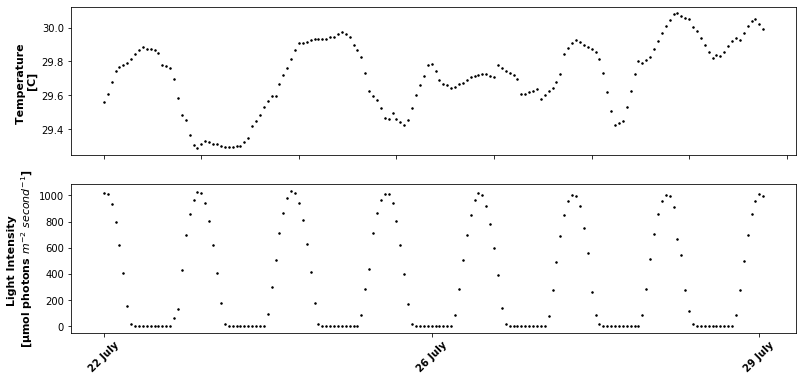

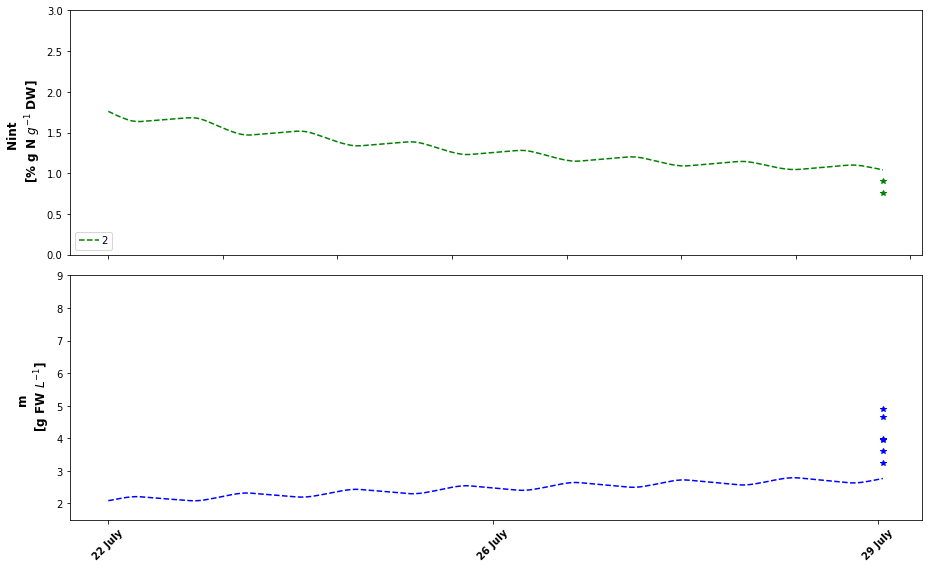

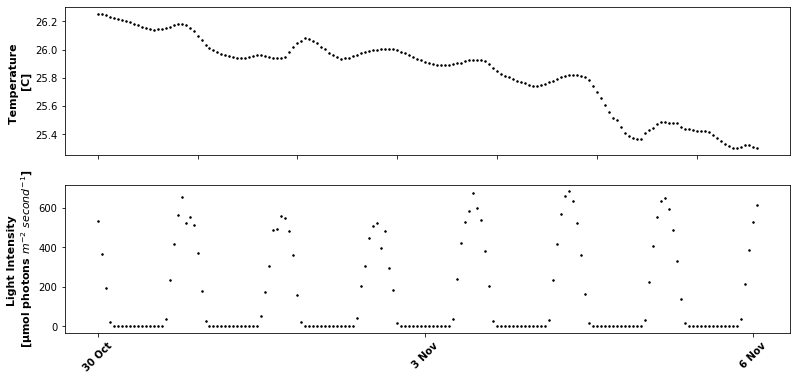

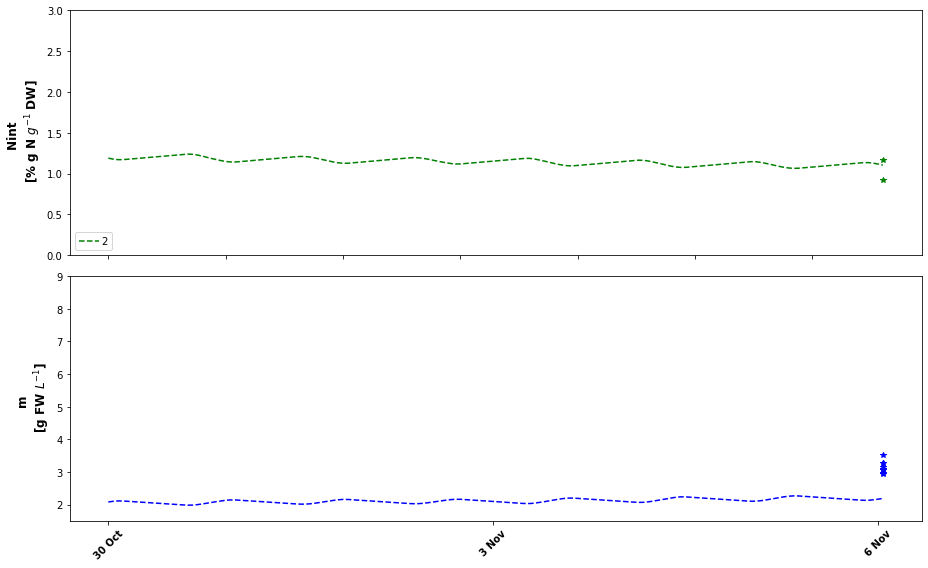

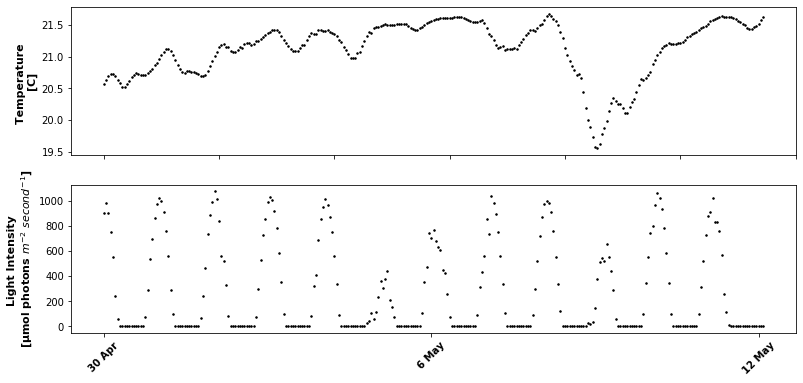

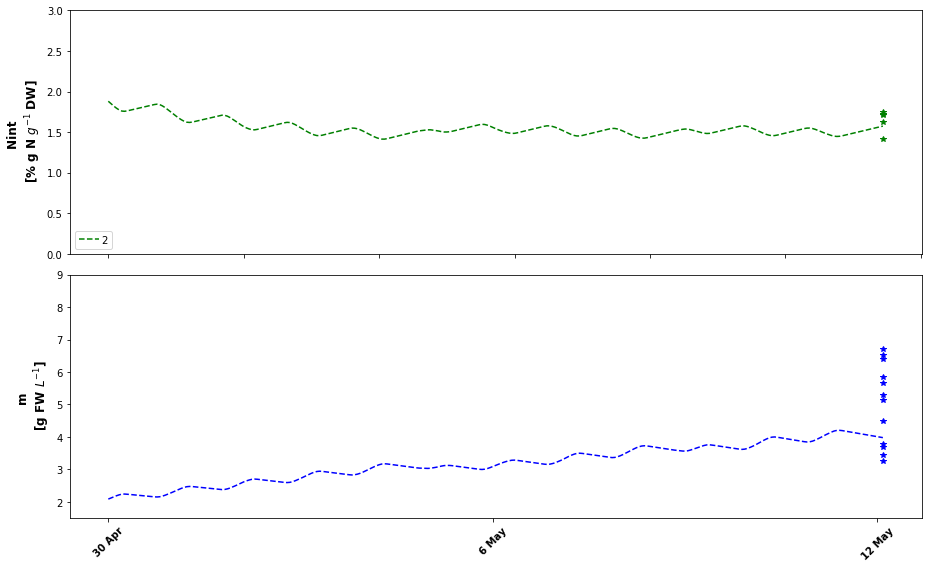

In [ ]:
#Offshore plots - without winter exp

mmod_all,mSRE3Exp,Nintmod_all,NintSRE3Exp = [],[],[],[]
mSRE3, NintSRE3 = [], []
mmodAll, mSRE3All, NintmodAll, NintSRE3All = [],[],[],[]

Experiments = [2,3,5]
xlabels_all = [['22 July','26 July', '29 July'],['30 Oct','3 Nov', '6 Nov'],['30 Apr', '6 May','12 May']]


Next_0_all = Next_all #[2.1,2.7,2.1]


m_0 = (20 / 1.44) * 0.15
Nint_0_all = [1.76, 1.19, 1.88] #two last experiments waiting for real data
VA = 1.44 / (0.3 * 0.15) # units: [g DW/ m^2] # A = w*l - conversion from volumetric to areal units
Z = 5 # m - depth of cages in water
for i in Experiments:
    DATA = []
    xlabels = xlabels_all[Experiments.index(i)]
    print('\nExperiment: #' + str(i) + '\n')

    df4Temp = df4Reduced[(df4Reduced.Exp == i)] 
    Samples = df4Temp.Sample.values
    Nint_0 = Nint_0_all[Experiments.index(i)]
    Next_0 = Next_0_all[Experiments.index(i)]
    
    t = np.arange(df4Temp['T'].values[0])
    T1 = '2019,07,22,0,0'
    T2 = df4Temp['Timei']
    T2 = T2.tolist()[0]
    t0 = Time_to_Hours(T1,T2)

    # light function
    I_reduced = I_plot[t0:t0+t[-1]+1]

    fI0 = interpolate.interp1d(t, I_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    # T function
    T_reduced = T_average[t0:t0+t[-1]+1] 


    fTemp0 = interpolate.interp1d(t, T_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    NEXT, NINT, M, TT = [],[],[],[]
    x0 = [Next_0,Nint_0,m_0]  
    
    # model simulation

    # setup initial conditions

    x = odeint(Offshore_constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                           Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))
        
    NEXT.append(x[: , 0]) #
    NINT.append(x[: , 1]) #
    M.append(x[: , 2])    #
    TT.append(t)

    t_model = np.hstack(TT)
    Next_model = np.hstack(NEXT)
    Nint_model = np.hstack(NINT)
    m_model = np.hstack(M)
    
    
    mmod_all.append(m_model[-1])
    print('Initial Nint is: ' + str(round(Nint_0,3)))
    print('Initial biomass: ' + str(round(m_0,3)))
    print('Modeled biomass for Exp ' + str(i) + ': ' + str(round(float(mmod_all[-1]),3)))
    Nintmod_all.append(Nint_model[-1])
    print('Modeled Nint for Exp ' + str(i) + ': ' + str(round(float(Nintmod_all[-1]),3)))
    print('Modeled Next: ' + str(round(float(Next_model[-1]),3)) + '\n')
    
    # plot I and T
    fig2, ax2 = plt.subplots(2,1,figsize=(13,6))
    ax2[0].plot(t,T_reduced,'.',markersize=3,color='black')
    ax2[1].plot(t,I_reduced,'.',markersize=3,color='k')

    ax2[0].set_ylabel('Temperature \n[C]',fontsize=11, weight="bold")
    ax2[1].set_ylabel('Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")

    ax2[0].set_xticklabels([])
    ax2[1].set_xticklabels([])
    ax2[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")
    
    # plot model
    fig, ax = plt.subplots(2,1,figsize=(13,8))
    ax[0].plot(t,NINT[-1],linestyle = '--',markersize=3.5,color='green')
    ax[0].set_ylim([0,3])
    ax[1].plot(t,M[-1],linestyle = '--',markersize=3.5,color='blue')
    ax[1].set_ylim([1.5,9])
    #col = len(l)
    ax[0].legend(Experiments,loc='lower left',fontsize='medium',markerscale=2,columnspacing = 0.2,handletextpad = 0.3)#,edgecolor='white')
        
    mexp_Temp,Nintexp_Temp = [],[]
    for j in Samples:
        
        print('\nSample: #' + str(math.floor(j)))
        mexp = df4Temp[df4Temp.Sample == j].DW
        mexp = mexp.tolist()[0]
        mexp_Temp.append(mexp)
        Nintexp = df4Temp[df4Temp.Sample == j].N
        Nintexp = Nintexp.tolist()[0]
        Nintexp_Temp.append(Nintexp)
        print('Measured biomass: ' + str(round(mexp,3)))
        print('Measured Nint: ' + str(round(Nintexp,3)) + "\n")      
        
        mSRE3Exp.append(((mexp-mmod_all[-1])/mmod_all[-1])**2)
        NintSRE3Exp.append(((Nintexp-Nintmod_all[-1])/Nintmod_all[-1])**2)       
        print('The Sqaure Relative Error for biomass is: ' + str(round(mSRE3Exp[-1],3)))
        print('The Sqaure Relative Error for Nint is: ' + str(round(NintSRE3Exp[-1],3)))
        ax[1].plot(t[-1],mexp,'*',markersize = 6,color='blue')
        ax[0].plot(t[-1],Nintexp,'*',markersize = 6,color='green')

    
    data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
    DATA.append(data)
    #ax[1].plot(t[-1],mexp_Temp[k-1][j],'*',markersize = 6,color=color)
    #ax[0].plot(t[-1],Nintexp_Temp[k-1][j],'*',markersize = 6,color=color)
    
    ax[0].set_xticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

    ax[0].set_ylabel('Nint \n [% g N $g^{-1}$ DW]',fontsize=12, weight="bold")
    ax[1].set_ylabel('m \n [g FW $L^{-1}$]',fontsize=12, weight="bold")

    plt.tight_layout()
    
mSRE3All.append(mSRE3Exp)
NintSRE3All.append(NintSRE3Exp)   

RMSREm3 = round((np.mean(mSRE3All))**0.5,3)
cleanedNintSRE3 = [x for x in NintSRE3All[0] if str(x) != 'nan']
RMSRENint3 = round((np.mean(cleanedNintSRE3))**0.5,3)


print('\nThe RMSRE of m in the offshore system is: ' + str(RMSREm3))
print('The RMSRE of Nint in the offshore system is: ' + str(RMSRENint3))

In [ ]:
# reverse calculate Next values for exp #4, starting May 8

mmod_all,mSRE3Exp,Nintmod_all,NintSRE3Exp = [],[],[],[]
mSRE3, NintSRE3 = [], []
mmodAll, mSRE3All, NintmodAll, NintSRE3All = [],[],[],[]
Y1, Y2 = [],[]
Experiments = [5]
xlabels_all = [['8 May', '10 May','12 May']]

Next_0_range = [0,0.3,0.6,0.9,1.2,1.5,1.8,2.1,2.4,2.7,3,3.3,3.6,3.9,4.2,4.5,4.8,5.1,5.4,5.7,6,6.3,6.6,6.9,7.2,7.5,7.8]
#Next_0_all = []
m_0 = 6
Nint_0_all = [Nintmin]
VA = 1.44 / (0.3 * 0.15) * 2 # units: [g DW/ m^2] # A = w*l - conversion from volumetric to areal units (VA*2 because of wave effect)
Z = 5 # m - depth of cages in water

for i in Experiments:
    All_RMSREm3,All_RMSRENint3 = [],[]
    for k in Next_0_range:
        mSRE3Exp,NintSRE3Exp = [],[]
        Next_0 = k
        DATA = []
        xlabels = xlabels_all[0]
        #print('\nExperiment: #' + str(i) + '\n')

        df4Temp = df4Reduced[(df4Reduced.Exp == i)] 
        Samples = df4Temp.Sample.values
        Nint_0 = 0.8#Nint_0_all[0]
        #Next_0 = Next_0_all[i-2]

        t = np.arange(df4Temp['Tm'].values[0])

        T1 = '2019,07,22,0,0'
        T2 = df4Temp['Timem']
        T2 = T2.tolist()[0]
        t0 = Time_to_Hours(T1,T2)

        # light function
        I_reduced = I_plot[t0:t0+t[-1]+1]

        #print(I_reduced)
        fI0 = interpolate.interp1d(t, I_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")

        # T function
        T_reduced = T_average[t0:t0+t[-1]+1] 
        #print(T_reduced)

        fTemp0 = interpolate.interp1d(t, T_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")

        NEXT, NINT, M, TT = [],[],[],[]
        x0 = [Next_0,Nint_0,m_0]  

        # model simulation

        # setup initial conditions

        x = odeint(Offshore_constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                               Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))

        NEXT.append(x[: , 0]) #
        NINT.append(x[: , 1]) #
        M.append(x[: , 2])    #
        TT.append(t)

        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)


        mmod_all.append(m_model[-1])
        Nintmod_all.append(Nint_model[-1])

        mexp_Temp,Nintexp_Temp = [],[]
        for j in Samples:

            mexp = df4Temp[df4Temp.Sample == j].DW
            mexp = mexp.tolist()[0]
            mexp_Temp.append(mexp)
            Nintexp = df4Temp[df4Temp.Sample == j].N
            Nintexp = Nintexp.tolist()[0]
            Nintexp_Temp.append(Nintexp)
      

            mSRE3Exp.append(((mexp-mmod_all[-1])/mmod_all[-1])**2)
            NintSRE3Exp.append(((Nintexp-Nintmod_all[-1])/Nintmod_all[-1])**2)       


        data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
        DATA.append(data)

        mSRE3All.append(mSRE3Exp)
        NintSRE3All.append(NintSRE3Exp)
    

        RMSREm3 = round((np.mean(mSRE3Exp))**0.5,3)
        cleanedNintSRE3 = [x for x in NintSRE3Exp if str(x) != 'nan']

        RMSRENint3 = round((np.mean(cleanedNintSRE3))**0.5,3)
        All_RMSREm3.append(RMSREm3)
        All_RMSRENint3.append(RMSRENint3)
    Y1.append(All_RMSREm3)
    Y2.append(All_RMSRENint3)
    print(i)

5



Experiment: #5

Initial Nint is: 0.8
Initial biomass: 6
Modeled biomass for Exp 5: 5.329
Modeled Nint for Exp 5: 3.655
Modeled Next: 6.6


Sample: #133
Measured biomass: 3.427
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.127
The Sqaure Relative Error for Nint is: nan

Sample: #134
Measured biomass: 4.479
Measured Nint: 1.742

The Sqaure Relative Error for biomass is: 0.025
The Sqaure Relative Error for Nint is: 0.274

Sample: #135
Measured biomass: 5.146
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.001
The Sqaure Relative Error for Nint is: nan

Sample: #136
Measured biomass: 5.281
Measured Nint: 1.718

The Sqaure Relative Error for biomass is: 0.0
The Sqaure Relative Error for Nint is: 0.281

Sample: #137
Measured biomass: 3.781
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.084
The Sqaure Relative Error for Nint is: nan

Sample: #138
Measured biomass: 3.25
Measured Nint: 1.715

The Sqaure Relative Error for biomass is: 0.152
The

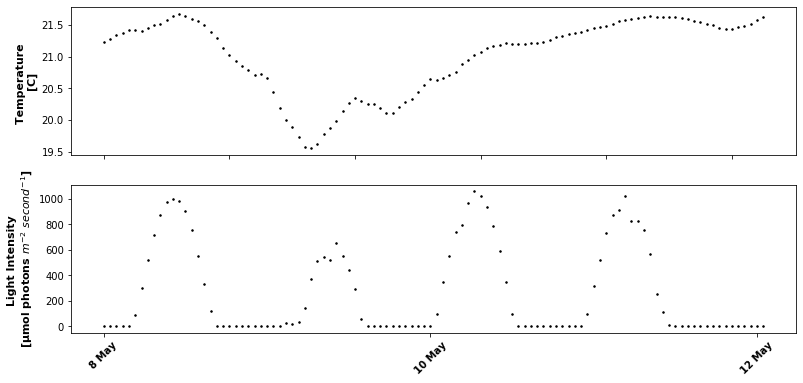

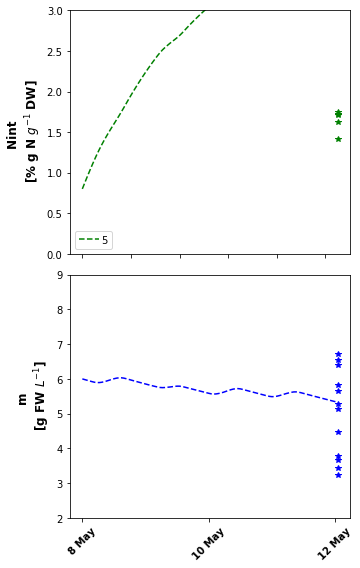

In [ ]:
#Offshore plots -   exp #5


mmod_all,mSRE3Exp,Nintmod_all,NintSRE3Exp = [],[],[],[]
mSRE3, NintSRE3 = [], []
mmodAll, mSRE3All, NintmodAll, NintSRE3All = [],[],[],[]

Experiments = [5]
xlabels_all = [['8 May', '10 May','12 May']]


Next_0_all = [6.6]#2.7]
#Next_0 = 0.8

m_0 = 6
Nint_0_all = [0.8] #two last experiments waiting for real data
VA = 1.44 / (0.3 * 0.15) * 2 # units: [g DW/ m^2] # A = w*l - conversion from volumetric to areal units
Z = 5 # m - depth of cages in water
for i in Experiments:
    DATA = []
    xlabels = xlabels_all[Experiments.index(i)]
    print('\nExperiment: #' + str(i) + '\n')

    df4Temp = df4Reduced[(df4Reduced.Exp == i)] 
    Samples = df4Temp.Sample.values
    Nint_0 = Nint_0_all[Experiments.index(i)]
    Next_0 = Next_0_all[Experiments.index(i)]
    
    t = np.arange(df4Temp['Tm'].values[0])
    T1 = '2019,07,22,0,0'
    T2 = df4Temp['Timem']
    T2 = T2.tolist()[0]
    t0 = Time_to_Hours(T1,T2)

    # light function
    I_reduced = I_plot[t0:t0+t[-1]+1]
    #print(I_reduced)
    fI0 = interpolate.interp1d(t, I_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    # T function
    T_reduced = T_average[t0:t0+t[-1]+1] 
    #print(T_reduced)

    fTemp0 = interpolate.interp1d(t, T_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    NEXT, NINT, M, TT = [],[],[],[]
    x0 = [Next_0,Nint_0,m_0]  
    
    # model simulation

    # setup initial conditions

    x = odeint(Offshore_constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                           Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))
        
    NEXT.append(x[: , 0]) #
    NINT.append(x[: , 1]) #
    M.append(x[: , 2])    #
    TT.append(t)

    t_model = np.hstack(TT)
    Next_model = np.hstack(NEXT)
    Nint_model = np.hstack(NINT)
    m_model = np.hstack(M)
    
    
    mmod_all.append(m_model[-1])
    print('Initial Nint is: ' + str(round(Nint_0,3)))
    print('Initial biomass: ' + str(round(m_0,3)))
    print('Modeled biomass for Exp ' + str(i) + ': ' + str(round(float(mmod_all[-1]),3)))
    Nintmod_all.append(Nint_model[-1])
    print('Modeled Nint for Exp ' + str(i) + ': ' + str(round(float(Nintmod_all[-1]),3)))
    print('Modeled Next: ' + str(round(float(Next_model[-1]),3)) + '\n')
    
    # plot I and T
    fig2, ax2 = plt.subplots(2,1,figsize=(13,6))
    ax2[0].plot(t,T_reduced,'.',markersize=3,color='black')
    ax2[1].plot(t,I_reduced,'.',markersize=3,color='k')

    ax2[0].set_ylabel('Temperature \n[C]',fontsize=11, weight="bold")
    ax2[1].set_ylabel('Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")

    ax2[0].set_xticklabels([])
    ax2[1].set_xticklabels([])
    ax2[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")
    
    # plot model
    fig, ax = plt.subplots(2,1,figsize=(5.1,8))
    ax[0].plot(t,NINT[-1],linestyle = '--',markersize=3.5,color='green')
    ax[0].set_ylim([0.5,5.5])
    ax[1].plot(t,M[-1],linestyle = '--',markersize=3.5,color='blue')

    #col = len(l)
    ax[0].legend(Experiments,loc='lower left',fontsize='medium',markerscale=2,columnspacing = 0.2,handletextpad = 0.3)#,edgecolor='white')
        
    mexp_Temp,Nintexp_Temp = [],[]
    for j in Samples:
        
        print('\nSample: #' + str(math.floor(j)))
        mexp = df4Temp[df4Temp.Sample == j].DW
        mexp = mexp.tolist()[0]
        mexp_Temp.append(mexp)
        Nintexp = df4Temp[df4Temp.Sample == j].N
        Nintexp = Nintexp.tolist()[0]
        Nintexp_Temp.append(Nintexp)
        print('Measured biomass: ' + str(round(mexp,3)))
        print('Measured Nint: ' + str(round(Nintexp,3)) + "\n")      
        
        mSRE3Exp.append(((mexp-mmod_all[-1])/mmod_all[-1])**2)
        NintSRE3Exp.append(((Nintexp-Nintmod_all[-1])/Nintmod_all[-1])**2)       
        print('The Sqaure Relative Error for biomass is: ' + str(round(mSRE3Exp[-1],3)))
        print('The Sqaure Relative Error for Nint is: ' + str(round(NintSRE3Exp[-1],3)))
        ax[1].plot(t[-1],mexp,'*',markersize = 6,color='blue')
        ax[0].plot(t[-1],Nintexp,'*',markersize = 6,color='green')

    
    data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
    DATA.append(data)
    #ax[1].plot(t[-1],mexp_Temp[k-1][j],'*',markersize = 6,color=color)
    #ax[0].plot(t[-1],Nintexp_Temp[k-1][j],'*',markersize = 6,color=color)
    
    ax[0].set_xticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

    ax[0].set_ylabel('Nint \n [% g N $g^{-1}$ DW]',fontsize=12, weight="bold")
    ax[0].set_ylim([0,3])
    ax[1].set_ylabel('m \n [g FW $L^{-1}$]',fontsize=12, weight="bold")
    ax[1].set_ylim([2,9])

    plt.tight_layout()
    
mSRE3All.append(mSRE3Exp)
NintSRE3All.append(NintSRE3Exp)
    

RMSREm3 = round((np.mean(mSRE3All))**0.5,3)
cleanedNintSRE3 = [x for x in NintSRE3All[0] if str(x) != 'nan']
#print(cleanedNintSRE3)
RMSRENint3 = round((np.mean(cleanedNintSRE3))**0.5,3)


#RMSRENint2 = round((np.mean(cleanedNintSRE2))**0.5,3)
print('\nThe RMSRE of m in the offshore system is: ' + str(RMSREm3))
print('The RMSRE of Nint in the offshore system is: ' + str(RMSRENint3))